# Code for Entry 1 - Module 2

Entry for the Complex Systems ePortfolio created by group 6. 

**Group members**: Djourdan Johnson, Jacuqot Qiu, Lotte Michels, Nawat Nawati Azhati, Nuo Xu, Xuelin Wei

In [7]:
!pip install sktime
!pip install statsmodels

In [8]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sktime.param_est.stationarity import StationarityADF, StationarityKPSS
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import hilbert
from scipy.stats import pearsonr
import seaborn as sns

In [9]:
# Load time-series datafiles (from the sensors) and print some informative metadata
data = pd.read_csv("/kaggle/input/beehive-dataset/D1_sensor_data.csv", sep=",")
print('The sensor data contains {} rows (measurements) and {} columns (variables)'.format(data.shape[0], data.shape[1]))
print('The variables are:', list(data.columns))
nr_hives = len(set(data['tag_number']))
print('The data contains information about {} different hives'.format(nr_hives))



The sensor data contains 960809 rows (measurements) and 30 columns (variables)
The variables are: ['published_at', 'temperature', 'humidity', 'tag_number', 'beehub_name', 'geolocation', 'hive_power', 'lat', 'long', 'date', 'time', 'hz_122.0703125', 'hz_152.587890625', 'hz_183.10546875', 'hz_213.623046875', 'hz_244.140625', 'hz_274.658203125', 'hz_305.17578125', 'hz_335.693359375', 'hz_366.2109375', 'hz_396.728515625', 'hz_427.24609375', 'hz_457.763671875', 'hz_488.28125', 'hz_518.798828125', 'hz_549.31640625', 'hz_579.833984375', 'audio_density', 'audio_density_ratio', 'density_variation']
The data contains information about 85 different hives


In [10]:
# Display the top of the dataframe to get an idea of what we're working with
print(data.head(5))

                published_at  temperature  humidity  tag_number   beehub_name  \
0  2020-04-16 04:30:37+00:00        19.98     38.46      200602  nectar-bh131   
1  2020-04-16 04:45:37+00:00        19.96     38.47      200602  nectar-bh131   
2  2020-04-16 05:00:37+00:00        19.95     38.47      200602  nectar-bh131   
3  2020-04-16 05:15:37+00:00        19.93     38.50      200602  nectar-bh131   
4  2020-04-16 05:30:37+00:00        19.93     38.50      200602  nectar-bh131   

   geolocation  hive_power  lat  long        date  ... hz_396.728515625  \
0  POINT (0 0)      -7.518  0.0   0.0  2020-04-16  ...           -12.05   
1  POINT (0 0)      -4.783  0.0   0.0  2020-04-16  ...           -13.17   
2  POINT (0 0)      -9.349  0.0   0.0  2020-04-16  ...           -12.88   
3  POINT (0 0)     -10.000  0.0   0.0  2020-04-16  ...           -12.54   
4  POINT (0 0)     -10.000  0.0   0.0  2020-04-16  ...           -11.37   

   hz_427.24609375  hz_457.763671875  hz_488.28125  hz_518.798

In [11]:
# Define the hive and variables of interest

# Filter the data for tag_number 202204
hive = 202204 # ID = without the first 2, but the sensor data contains a number 2 before each ID
# 02204 is in Coté. GPS points: 46°44’30.21’’N, 71°28’28.41’’O
variables = ['temperature', 'humidity', 'tag_number', 'geolocation', 'hive_power', 'date', 'time', 'beehub_name']

hive_data = data.loc[data['tag_number'] == hive, variables].reset_index()
print('The sensor data for hive {} contains {} measurements'.format(hive, hive_data.shape[0]))
#print(hive_data.head(-5))

# Remove duplicate timepoints
hive_data['datetime'] = pd.to_datetime(hive_data['date'] + ' ' + hive_data['time'])
hive_data = hive_data.drop_duplicates(subset='datetime')
print('The sensor data for hive {} contains {} measurements after duplicate timepoint removal'.format(hive, hive_data.shape[0]))

hive_data.head()

The sensor data for hive 202204 contains 16037 measurements
The sensor data for hive 202204 contains 12432 measurements after duplicate timepoint removal


,index,temperature,humidity,tag_number,geolocation,hive_power,date,time,beehub_name,datetime
0,291844,28.98,44.97,202204,POINT (-71.474 46.742),-8.593,2020-05-26,10:54:03,nectar-bh121,2020-05-26 10:54:03
1,291845,33.56,55.20,202204,POINT (-71.474 46.742),4.590,2020-05-26,11:09:03,nectar-bh121,2020-05-26 11:09:03
2,297339,35.28,55.48,202204,POINT (-71.47499999999999 46.742),1.708,2020-05-26,14:05:52,nectar-bh121,2020-05-26 14:05:52
3,297349,36.20,53.58,202204,POINT (-71.47499999999999 46.742),4.768,2020-05-26,14:20:52,nectar-bh121,2020-05-26 14:20:52
4,297365,36.42,50.59,202204,POINT (-71.47499999999999 46.742),1.637,2020-05-26,14:35:52,nectar-bh121,2020-05-26 14:35:52


In [12]:
# Extract data for different periods in the beehive

# Extract one month of data
days = [x for x in hive_data['date'] if '-08-' in x]
#print('Collected data for', len(days), 'days')
hive_month = hive_data[hive_data['date'].isin(days)].reset_index()
# print(hive_month) # check that measurements are reported every 15 minutes

# Extract one week of data
week = ['2020-08-08', '2020-08-09', '2020-08-10', '2020-08-11', '2020-08-12', '2020-08-13', '2020-08-14']
hive_week = hive_data[hive_data['date'].isin(week)].reset_index()
#print(hive_day) # check that measurements are reported every 15 minutes

# Extract one single day
hive_day = hive_data[hive_data['date']=='2020-08-12'].reset_index()
#print(hive_day) # check that measurements are reported every 15 minutes


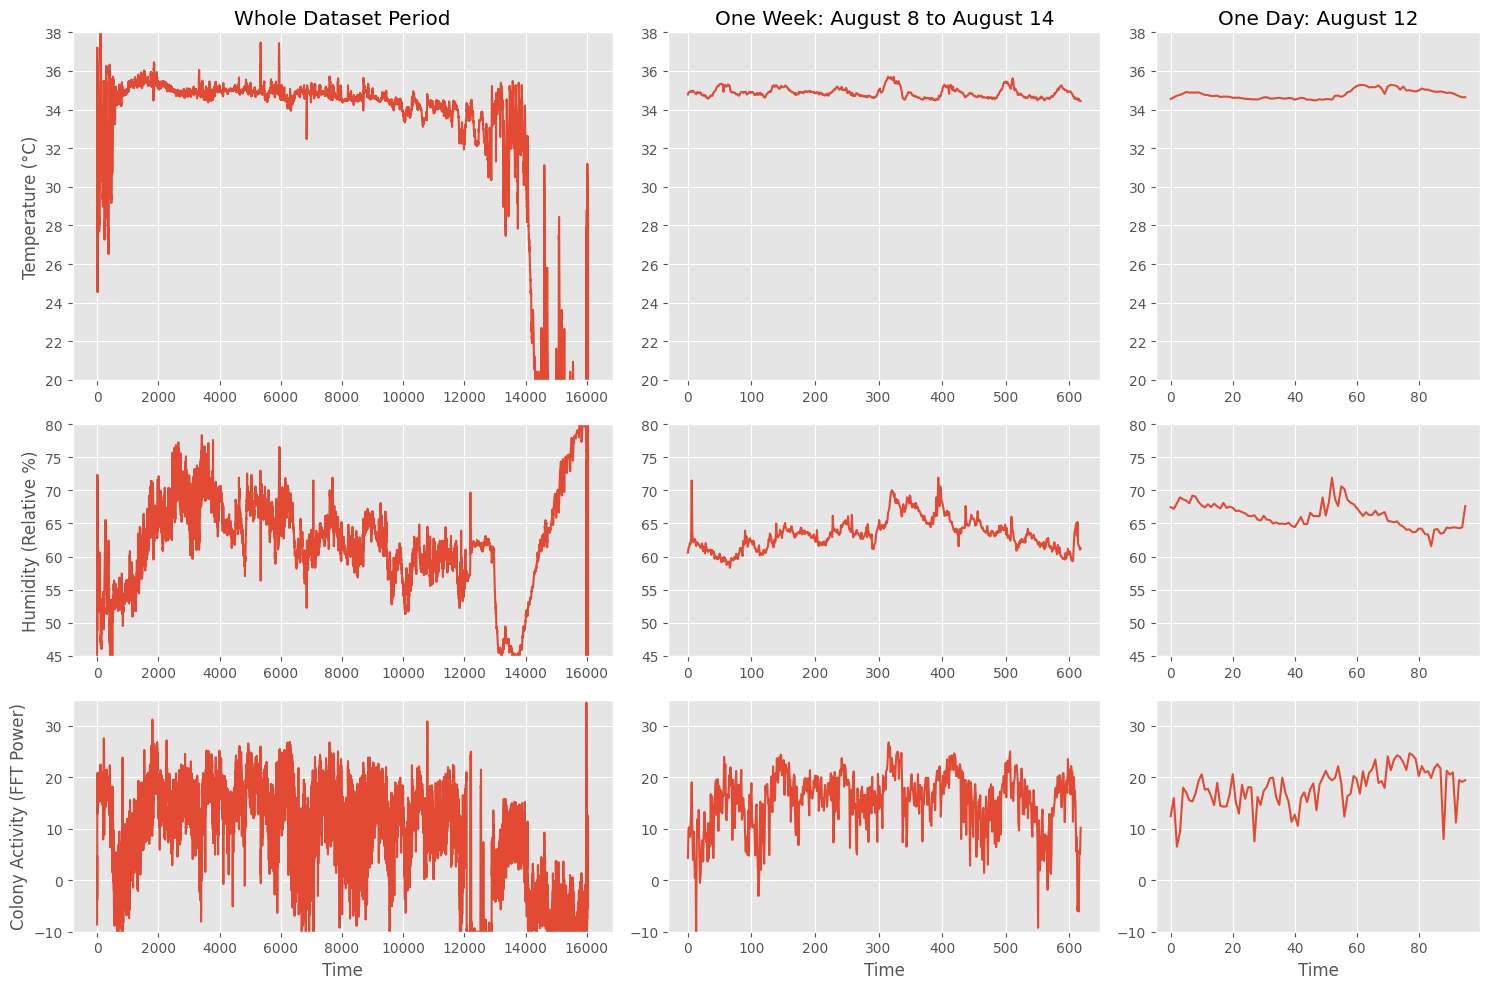

In [13]:
# VISUALIZATION FOR SECTION 3.1

# Make one plot for the temporal patterns for different time lengths

from matplotlib import gridspec

plt.style.use('ggplot')

# fig, ax = plt.subplots(3, 3, figsize=(15, 10))

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 3, width_ratios=[2.5, 2, 1.5], height_ratios=[1.5, 1, 1])  # Set column widths

# Create subplots based on the GridSpec
ax = [ [plt.subplot(gs[row, col]) for col in range(3)] for row in range(3) ]

period_data = [hive_data, hive_week, hive_day]
#['temperature', 'humidity', 'hive_power']

for idx, period in zip(range(0, 4), period_data):
    
    # Temperature
    ax[0][idx].plot(period['temperature'])
    ax[0][idx].set_ylim(20, 38)
    
    # Humidity
    ax[1][idx].plot(period['humidity'])
    ax[1][idx].set_ylim(45, 80)
    
    # Power
    ax[2][idx].plot(period['hive_power'])
    ax[2][idx].set_xlabel('Time')
    ax[2][idx].set_ylim(-10, 35)
        
    ax[0][idx].grid(True)
    ax[1][idx].grid(True)
    ax[2][idx].grid(True)

ax[0][0].set_ylabel('Temperature (°C)')
ax[1][0].set_ylabel('Humidity (Relative %)')
ax[2][0].set_ylabel('Colony Activity (FFT Power)')

ax[0][0].set_title('Whole Dataset Period')
ax[0][1].set_title('One Week: August 8 to August 14')
ax[0][2].set_title('One Day: August 12')
fig.tight_layout()
plt.show()

/tmp/ipykernel_31/2467793977.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  one_ds_hive_week = hive_week_dt_index.resample('1H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
/tmp/ipykernel_31/2467793977.py:7: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  two_ds_hive_week = hive_week_dt_index.resample('2H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
/tmp/ipykernel_31/2467793977.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  three_ds_hive_week = hive_week_dt_index.resample('5H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
/tmp/ipykernel_31/2467793977.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  one_ds_hive_day = hive_day_dt_index.resample('1H').mean(numeric_only=True) # resample to

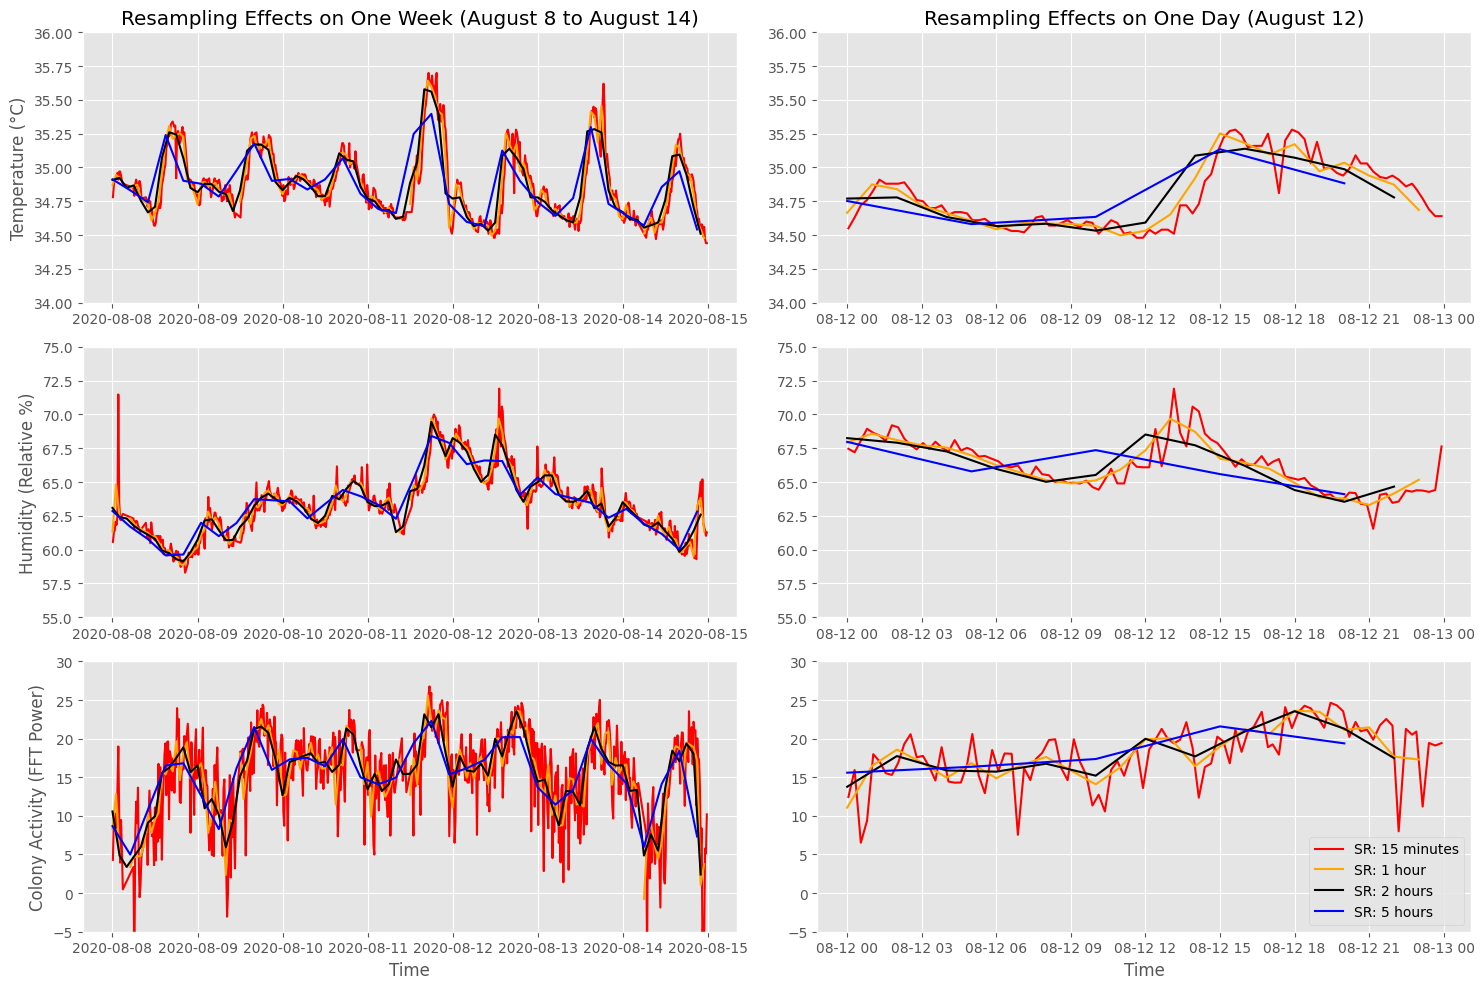

In [14]:
# VISUALIZATION FOR SECTION 3.2

# Apply three different degrees of downsampling
# For the weekly data
hive_week_dt_index = hive_week.set_index('datetime')
one_ds_hive_week = hive_week_dt_index.resample('1H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
two_ds_hive_week = hive_week_dt_index.resample('2H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
three_ds_hive_week = hive_week_dt_index.resample('5H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)

# For the daily data
hive_day_dt_index = hive_day.set_index('datetime')
one_ds_hive_day = hive_day_dt_index.resample('1H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
two_ds_hive_day = hive_day_dt_index.resample('2H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)
three_ds_hive_day = hive_day_dt_index.resample('5H').mean(numeric_only=True) # resample to 1 hour (rather than 15 minutes)

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2, width_ratios=[1,1], height_ratios=[1, 1, 1])  # Set column widths

# Create subplots
ax = [ [plt.subplot(gs[row, col]) for col in range(2)] for row in range(3) ]

no_ds = [hive_week_dt_index, hive_day_dt_index]
one_ds = [one_ds_hive_week, one_ds_hive_day]
two_ds = [two_ds_hive_week, two_ds_hive_day]
three_ds = [three_ds_hive_week, three_ds_hive_day]

for idx, no, one, two, three in zip(range(0, 4), no_ds, one_ds, two_ds, three_ds):
    
    # Temperature
    ax[0][idx].plot(no['temperature'], color='red')
    ax[0][idx].plot(one['temperature'], color='orange')
    ax[0][idx].plot(two['temperature'], color='black')
    ax[0][idx].plot(three['temperature'], color='blue')
    ax[0][idx].set_ylim(34, 36)
    
    # Humidity
    ax[1][idx].plot(no['humidity'], color='red')
    ax[1][idx].plot(one['humidity'], color='orange')
    ax[1][idx].plot(two['humidity'], color='black')
    ax[1][idx].plot(three['humidity'], color='blue')
    ax[1][idx].set_ylim(55, 75)
    
    # Power
    ax[2][idx].plot(no['hive_power'], color='red')
    ax[2][idx].plot(one['hive_power'], color='orange')
    ax[2][idx].plot(two['hive_power'], color='black')
    ax[2][idx].plot(three['hive_power'], color='blue')
    ax[2][idx].set_xlabel('Time')
    ax[2][idx].set_ylim(-5, 30)
        
    ax[0][idx].grid(True)
    ax[1][idx].grid(True)
    ax[2][idx].grid(True)

ax[0][0].set_ylabel('Temperature (°C)')
ax[1][0].set_ylabel('Humidity (Relative %)')
ax[2][0].set_ylabel('Colony Activity (FFT Power)')

ax[0][0].set_title('Resampling Effects on One Week (August 8 to August 14)')
ax[0][1].set_title('Resampling Effects on One Day (August 12)')
ax[2][1].legend(['SR: 15 minutes', 'SR: 1 hour', 'SR: 2 hours', 'SR: 5 hours'])
fig.tight_layout()
plt.show()


<Figure size 640x480 with 0 Axes>

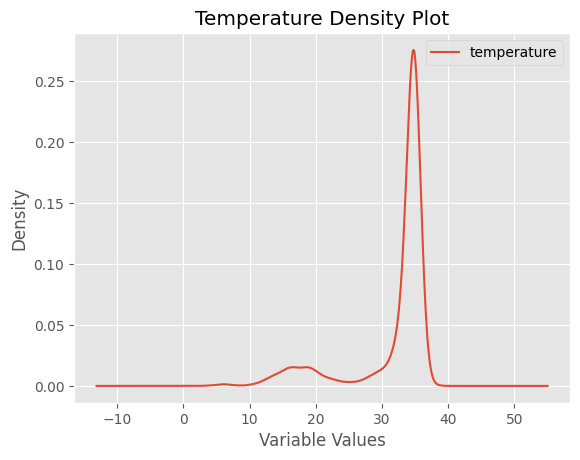

<Figure size 640x480 with 0 Axes>

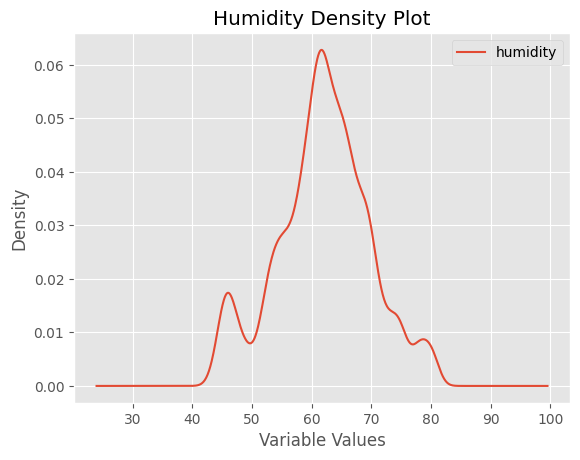

<Figure size 640x480 with 0 Axes>

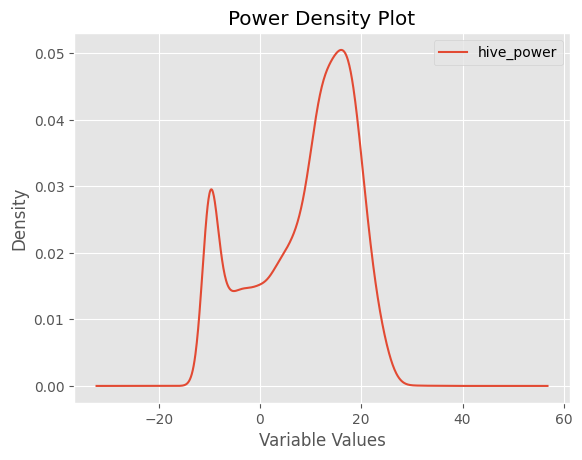

<Figure size 640x480 with 0 Axes>

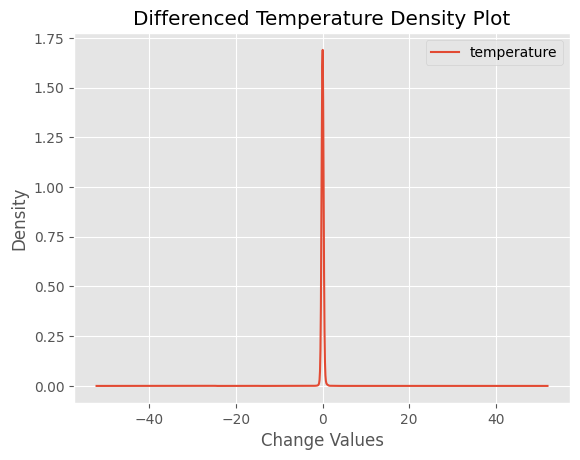

<Figure size 640x480 with 0 Axes>

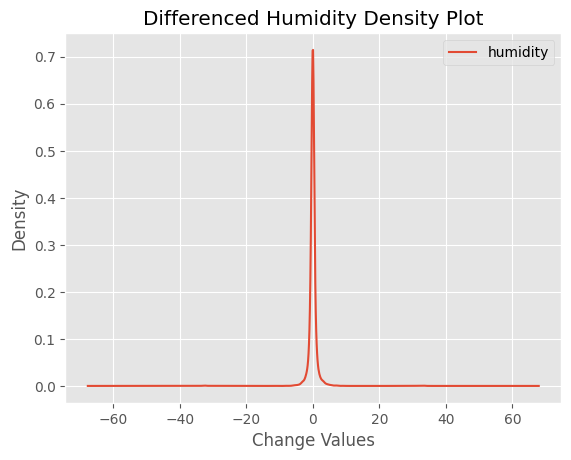

<Figure size 640x480 with 0 Axes>

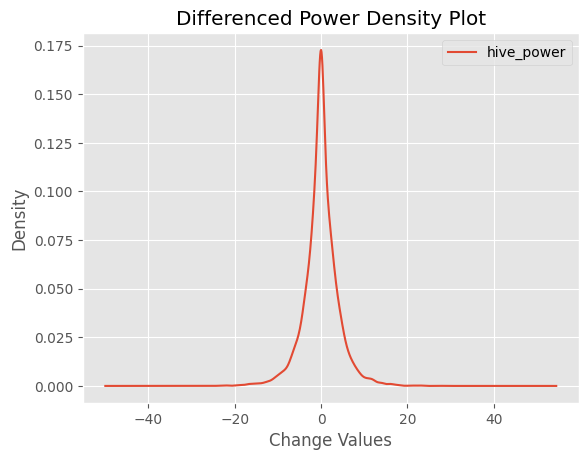

In [15]:
# VISUALIZATION FOR SECTION 4.1

# Create density plots to assess the stable points in the time series
ts_variables = ['temperature', 'humidity', 'hive_power']
titles = ['Temperature Density Plot', 'Humidity Density Plot', 'Power Density Plot']

for variable, title in zip(ts_variables, titles):
    plt.figure()
    pd.DataFrame(hive_data[variable]).plot(kind='density')
    plt.title(title)
    plt.xlabel('Variable Values')
    plt.show()

# Create density plots of the differences signal to assess stability in change in the signals
diff_vars = []
for ts_var in ts_variables:
    diff_vars.append(hive_data[ts_var].diff())
diff_titles = ['Differenced Temperature Density Plot', 'Differenced Humidity Density Plot', 'Differenced Power Density Plot']

for variable, title in zip(diff_vars, diff_titles):
    plt.figure()
    pd.DataFrame(variable).plot(kind='density')
    plt.title(title)
    plt.xlabel('Change Values')
    plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

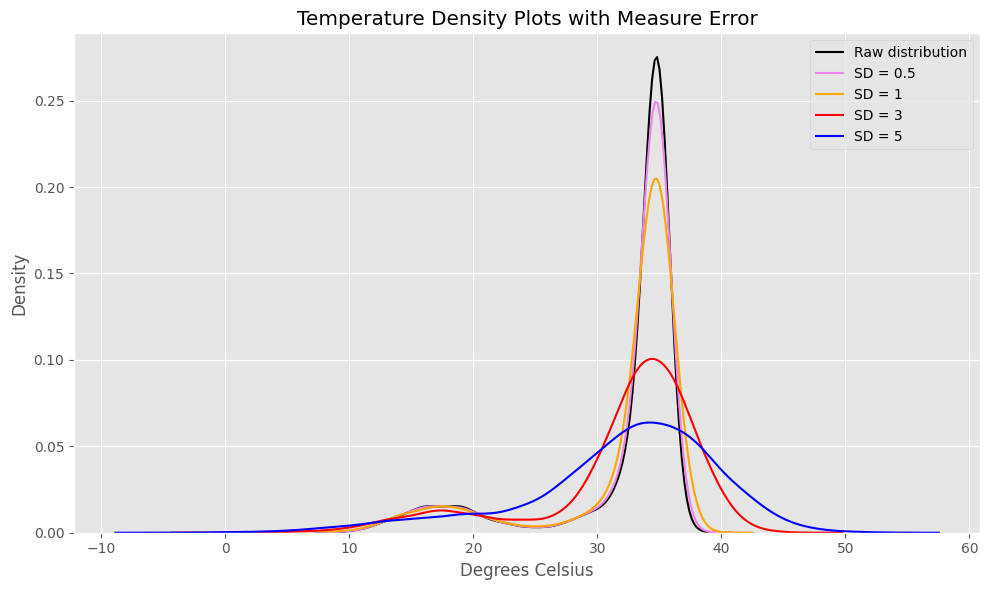

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

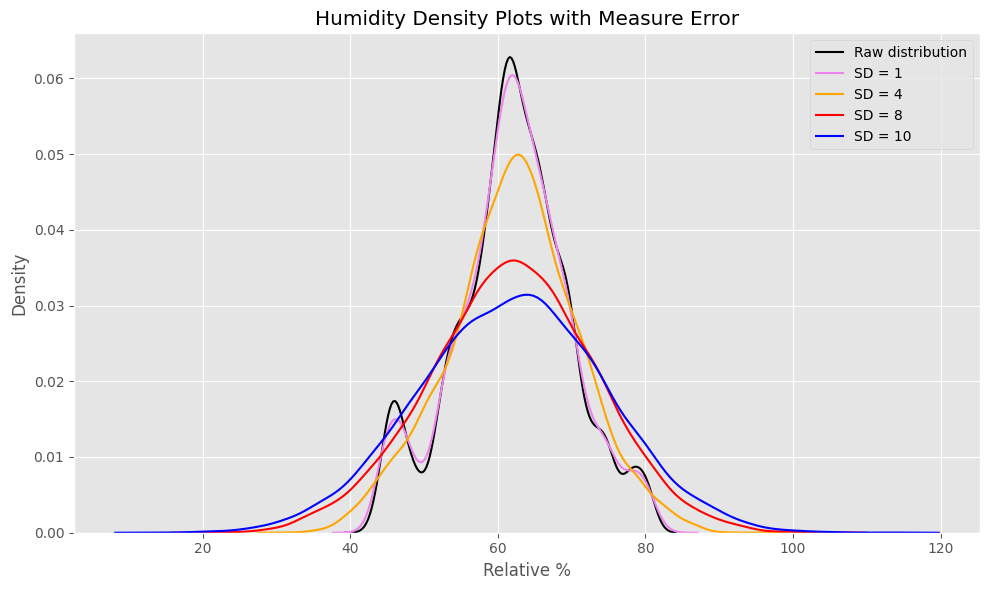

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

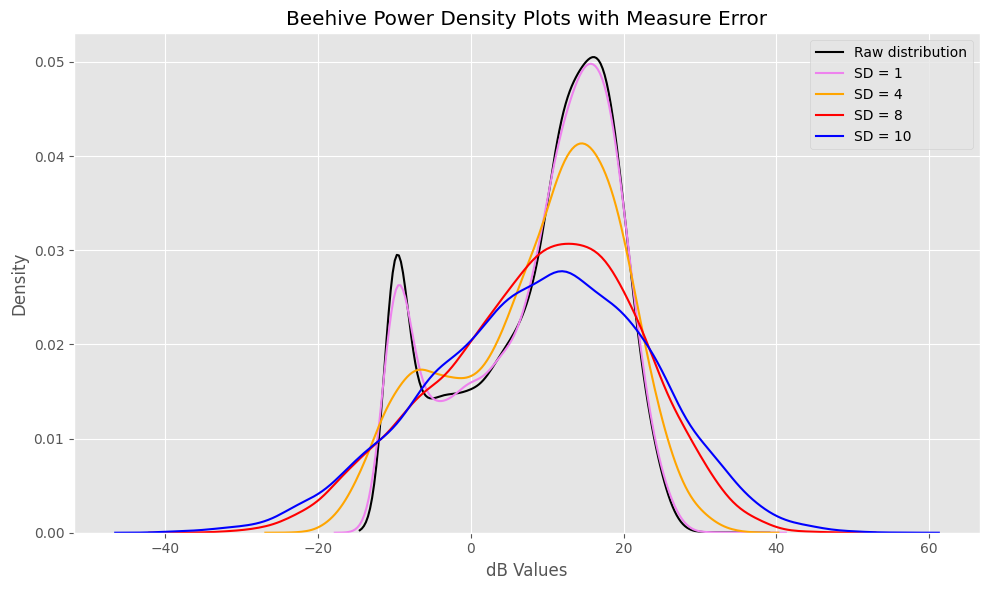

In [16]:
# VISUALIZATION FOR SECTION 4.1.1

# Explore resistance to noise

# Create measurement errors with increasing standard deviation

np.random.seed(2929)
signal_len = len(hive_data['temperature'])

# For temperature
a = hive_data['temperature'] + np.random.normal(0, 0.5, signal_len)
b = hive_data['temperature'] + np.random.normal(0, 1, signal_len)
c = hive_data['temperature'] + np.random.normal(0, 3, signal_len)
d = hive_data['temperature'] + np.random.normal(0, 5, signal_len)

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(hive_data['temperature'], label='Raw distribution', color='black')
sns.kdeplot(a, label='SD = 0.5', color='violet')
sns.kdeplot(b, label='SD = 1', color='orange')
sns.kdeplot(c, label='SD = 3', color='red')
sns.kdeplot( d, label='SD = 5', color='blue')
plt.title('Temperature Density Plots with Measure Error')
plt.xlabel('Degrees Celsius')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# For humidity
a = hive_data['humidity'] + np.random.normal(0, 1, signal_len)
b = hive_data['humidity'] + np.random.normal(0, 4, signal_len)
c = hive_data['humidity'] + np.random.normal(0, 8, signal_len)
d = hive_data['humidity'] + np.random.normal(0, 10, signal_len)

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(hive_data['humidity'], label='Raw distribution', color='black')
sns.kdeplot(a, label='SD = 1', color='violet')
sns.kdeplot(b, label='SD = 4', color='orange')
sns.kdeplot(c, label='SD = 8', color='red')
sns.kdeplot( d, label='SD = 10', color='blue')
plt.title('Humidity Density Plots with Measure Error')
plt.xlabel('Relative %')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

# For power
a = hive_data['hive_power'] + np.random.normal(0, 1, signal_len)
b = hive_data['hive_power'] + np.random.normal(0, 4, signal_len)
c = hive_data['hive_power'] + np.random.normal(0, 8, signal_len)
d = hive_data['hive_power'] + np.random.normal(0, 10, signal_len)

# Create the plot
plt.figure(figsize=(10, 6))
sns.kdeplot(hive_data['hive_power'], label='Raw distribution', color='black')
sns.kdeplot(a, label='SD = 1', color='violet')
sns.kdeplot(b, label='SD = 4', color='orange')
sns.kdeplot(c, label='SD = 8', color='red')
sns.kdeplot( d, label='SD = 10', color='blue')
plt.title('Beehive Power Density Plots with Measure Error')
plt.xlabel('dB Values')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [17]:
# STATISTICS FOR SECTION 4.2

# Compute basic statistical metrics
print(hive_data['temperature'].mean())
print(hive_data['temperature'].std())

print(hive_data['humidity'].mean())
print(hive_data['humidity'].std())

print(hive_data['hive_power'].mean())
print(hive_data['hive_power'].std())

31.835956402831407
6.234864783201278
61.963209459459456
7.81241436792619
8.788336792149291
10.0071899446967


In [18]:
# STATISTICS FOR SECTION 5

# ADF and KPSS 
ts_variables = ['temperature', 'humidity', 'hive_power']

print('STATIONARITY WITHOUT PRE-PROCESSING')
for ts_var in ts_variables:
    sty_est = StationarityADF()
    sty_est.fit(hive_data[ts_var])

    print(ts_var)
    print('ADF Stationary:', sty_est.get_fitted_params()["stationary"])
    print('ADF Statistic:', sty_est.get_fitted_params()["test_statistic"])
    print('ADF p-value:', sty_est.get_fitted_params()["pvalue"])

    sty_est = StationarityKPSS()
    sty_est.fit(hive_month[ts_var])
    print('KPSS Stationary:', sty_est.get_fitted_params()["stationary"])
    print('KPSS Statistic:', sty_est.get_fitted_params()["test_statistic"])
    print('KPSS p-value:', sty_est.get_fitted_params()["pvalue"], '\n')


STATIONARITY WITHOUT PRE-PROCESSING
temperature
ADF Stationary: False
ADF Statistic: -1.863355775692456
ADF p-value: 0.3494911016155064
KPSS Stationary: False
KPSS Statistic: 3.1694097259893823
KPSS p-value: 0.01 



/usr/local/lib/python3.11/dist-packages/sktime/param_est/stationarity/_statsmodels.py:255: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(


humidity
ADF Stationary: True
ADF Statistic: -3.163439017372846
ADF p-value: 0.022200930796034385
KPSS Stationary: False
KPSS Statistic: 2.611491439950441
KPSS p-value: 0.01 



/usr/local/lib/python3.11/dist-packages/sktime/param_est/stationarity/_statsmodels.py:255: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  res = kpss(


hive_power
ADF Stationary: True
ADF Statistic: -4.180336818391329
ADF p-value: 0.0007112596459315791
KPSS Stationary: True
KPSS Statistic: 0.3951473445963018
KPSS p-value: 0.07924683422573198 

